# Topic modeling on PWDB textual data

## Importing libraries

In [10]:
import spacy
from spacy.tokens import Token
from spacy.tokens.doc import Doc
from spacy.tokens.span import Span

nlp = spacy.load("en_core_web_sm")

import gensim
from gensim.models import LdaModel

from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.topic_visualizer import generate_wordcloud
from sem_covid.services.data_registry import Dataset
from sem_covid.services.sc_wrangling.data_cleaning import clean_text_from_specific_characters, clean_fix_unicode, \
    clean_remove_currency_symbols, clean_remove_emails, clean_remove_urls
import pyLDAvis.gensim_models
from typing import List, Union

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Fetching data from document store

In [2]:
pwdb = Dataset.PWDB.fetch()

document_corpus = pwdb['title'].map(str) + '. ' + \
                  pwdb['background_info_description'].map(str) + '. ' + \
                  pwdb['content_of_measure_description'].map(str) + '. ' + \
                  pwdb['use_of_measure_description'] + '. ' + \
                  pwdb['involvement_of_social_partners_description']

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100% (1288 of 1288) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


## Data preprocessing
- data cleanup
- turn corpus into spacy Docs

In [64]:
unused_characters = ["\\r", ">", "\n", "\\", "<", "''", "%", "...", "\'", '"', "(", "\n", "*", "1)", "2)", "3)",
                     "[", "]", "-", "_", "\r"]
document_corpus = document_corpus.apply(clean_text_from_specific_characters, characters=unused_characters)
document_corpus = document_corpus.apply(clean_fix_unicode)
document_corpus = document_corpus.apply(clean_remove_urls)
document_corpus = document_corpus.apply(clean_remove_emails)
document_corpus = document_corpus.apply(clean_remove_currency_symbols)
spacy_corpus = document_corpus.apply(nlp)


/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Defining filtering functions
 Helper functions for filtering spacy documents

In [181]:
spacy_stop_words = nlp.Defaults.stop_words

def filter_stop_words(doc: List[Token], stop_words: List[str] = nlp.Defaults.stop_words) -> List[Token]:
    """
        turn a spacy Doc into a list of token and remove stop words
    """
    return [token for token in doc if str(token.lower_) not in stop_words]

def filter_pos(doc:Doc, pos: Union[str,List[str]]) -> List[Token]:
    """
        filter out tokens that have the provided POS
    """
    if isinstance(pos,str):
        poses = [pos]
    else:
        poses = pos
    return [token for token in doc if token.pos_ not in poses]

def select_pos(doc:Doc, pos: Union[str,List[str]]) -> List[str]:
    """
        select tokens that have the desired POS
    """
    if isinstance(pos,str):
        poses = [pos]
    else:
        poses = pos
    return [token for token in doc if token.pos_ in poses]

def filter_stop_words_on_a_span_list(span_list: List[Span],
                                     stop_words: List[str] = nlp.Defaults.stop_words) -> List[str]:
    """
        Spacy noun phrases are provided as a list of Spans.
        Some noun phrases contain stop words, and we want those removed.
    """
    return list(filter(None, ["_".join(map(str,
                                           [token.lemma_ for token in filter_stop_words(span, stop_words)]
                                           )) for span in span_list]))


/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Preparing few corpora

Filter document tokens. Select only the needed/interesting tokens for Topic modeling:
   - all words,
   - nouns
   - verbs
   - noun phrases

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



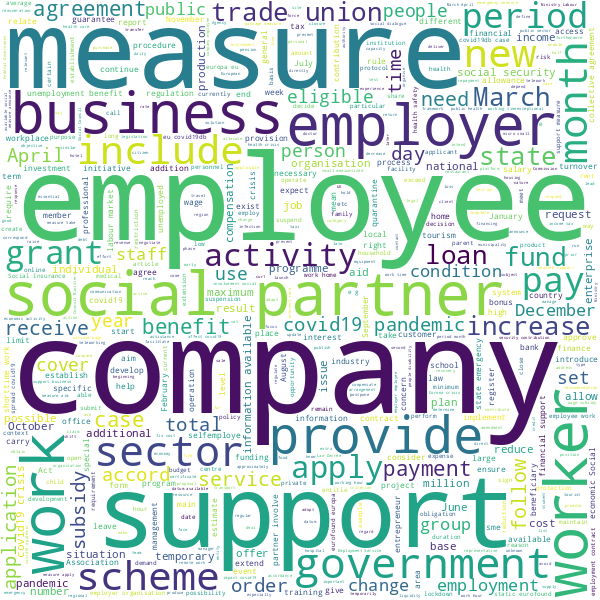

In [182]:
word_corpus = spacy_corpus.apply(filter_stop_words, stop_words=spacy_stop_words)
word_corpus = word_corpus.apply(filter_pos, pos="PUNCT")
word_corpus = word_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud( " ".join( [" ".join(doc) for doc in word_corpus]) )

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



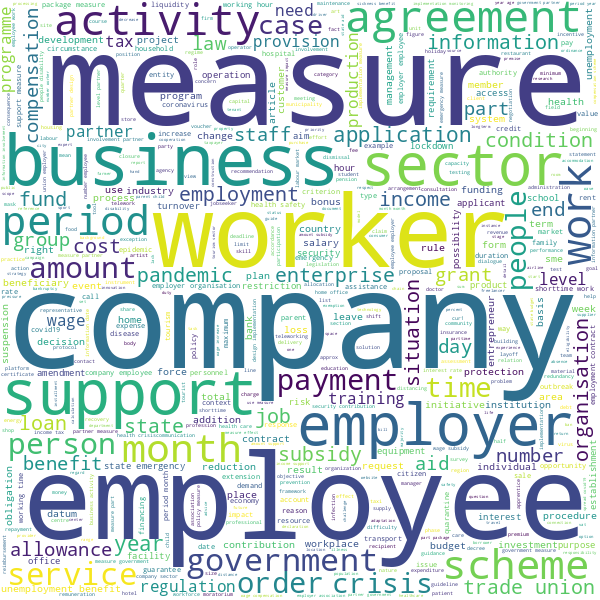

In [183]:
noun_corpus = spacy_corpus.apply(select_pos, pos="NOUN")
noun_corpus = noun_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud( " ".join( [" ".join(doc) for doc in noun_corpus]) )

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



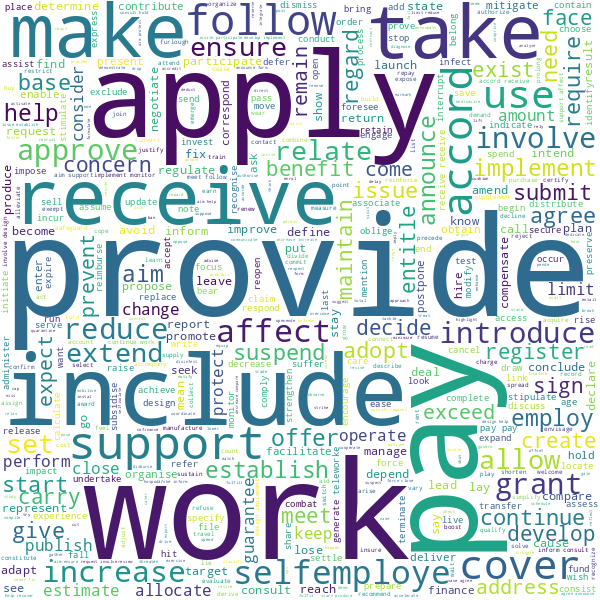

In [184]:
verb_corpus = spacy_corpus.apply(select_pos, pos="VERB")
verb_corpus = verb_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud( " ".join( [" ".join(doc) for doc in verb_corpus]) )

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



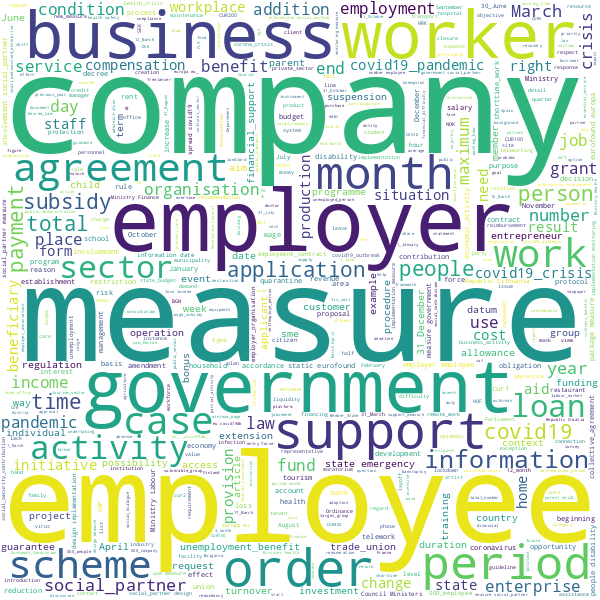

In [185]:
noun_phrase_corpus = spacy_corpus.apply(lambda x: x.noun_chunks)
noun_phrase_corpus = noun_phrase_corpus.apply(filter_stop_words_on_a_span_list)


generate_wordcloud( " ".join( [" ".join(doc) for doc in noun_phrase_corpus]) )

## Train LDA model

- create a dictionary and a corpus with each corpora
- train LDA model
- visualize the results

In [186]:
word_dictionary = gensim.corpora.Dictionary(word_corpus)
noun_dictionary = gensim.corpora.Dictionary(word_corpus)
verb_dictionary = gensim.corpora.Dictionary(verb_corpus)
noun_phrases_dictionary = gensim.corpora.Dictionary(noun_phrase_corpus)

word_gensim_corpus = [word_dictionary.doc2bow(docs) for docs in word_corpus]
noun_gensim_corpus = [noun_dictionary.doc2bow(docs) for docs in noun_corpus]
verb_gensim_corpus = [verb_dictionary.doc2bow(docs) for docs in verb_corpus]
noun_phrases_gensim_corpus = [noun_phrases_dictionary.doc2bow(docs) for docs in noun_phrase_corpus]

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [187]:
word_lda_model = LdaModel(corpus=word_gensim_corpus, num_topics=6, id2word=word_dictionary, chunksize=30, random_state=40)
noun_lda_model = LdaModel(corpus=noun_gensim_corpus, num_topics=6, id2word=noun_dictionary, chunksize=30, random_state=40)
verb_lda_model = LdaModel(corpus=verb_gensim_corpus, num_topics=4, id2word=verb_dictionary, chunksize=20, random_state=40)
noun_phrases_lda_model = LdaModel(corpus=noun_phrases_gensim_corpus, num_topics=5, id2word=noun_phrases_dictionary, chunksize=30, random_state=40)

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [188]:
pyLDAvis.enable_notebook()
word_visualization = pyLDAvis.gensim_models.prepare(word_lda_model, word_gensim_corpus, word_dictionary)
word_visualization

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.118511  0.105036       1        1  31.094534
5      0.069801  0.000286       2        1  22.492658
0     -0.015411  0.194283       3        1  18.492824
4      0.252602 -0.010055       4        1  13.447407
2     -0.156079 -0.069374       5        1   7.363309
3     -0.032402 -0.220176       6        1   7.109269, topic_info=          Term         Freq        Total Category  logprob  loglift
607    benefit   825.000000   825.000000  Default  30.0000  30.0000
309     worker  1525.000000  1525.000000  Default  29.0000  29.0000
68      period  1067.000000  1067.000000  Default  28.0000  28.0000
97        work  2096.000000  2096.000000  Default  27.0000  27.0000
254        pay  1175.000000  1175.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
407       case   115.510700   514.866181   Topic6  -5.0673   1.1492
242      month   134.853185   885.765411   Topic6  -4.9125   0.7615
751  situation   100.241003   462.077580   Topic6  -5.2091   1.1156
97        work   118.233759  2096.240690   Topic6  -5.0440  -0.2315
440     person    97.914629   565.100329   Topic6  -5.2326   0.8909

[454 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1076      1  0.670168      1
1076      2  0.106201      1
1076      3  0.069580      1
1076      4  0.003662      1
1076      5  0.148316      1
...     ...       ...    ...
100       3  0.019653   year
100       4  0.089192   year
100       5  0.095239   year
100       6  0.001512   year
1791      5  0.945821  České

[1052 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 1, 5, 3, 4])

In [189]:
noun_visualization = pyLDAvis.gensim_models.prepare(noun_lda_model, noun_gensim_corpus, noun_dictionary)
noun_visualization

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.233032 -0.041550       1        1  46.770466
0     -0.195610  0.172921       2        1  25.845607
2     -0.079739 -0.234801       3        1  16.463095
4      0.082010  0.138205       4        1   6.623027
3      0.193048 -0.054616       5        1   4.115477
5      0.233323  0.019840       6        1   0.182328, topic_info=             Term         Freq        Total Category  logprob  loglift
1303         loan   553.000000   553.000000  Default  30.0000  30.0000
607       benefit   456.000000   456.000000  Default  29.0000  29.0000
43       employee  2203.000000  2203.000000  Default  28.0000  28.0000
18      agreement   917.000000   917.000000  Default  27.0000  27.0000
255       payment   755.000000   755.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2254   collateral     0.017999    11.881114   Topic6  -9.4445  -0.1853
4054  aquaculture     0.017592     9.181410   Topic6  -9.4674   0.0496
5264     treasury     0.016502     8.260473   Topic6  -9.5314   0.0914
1303         loan     0.018437   553.428853   Topic6  -9.4205  -4.0024
100          year     0.017004   618.474001   Topic6  -9.5014  -4.1944

[406 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
101        1  0.943503          .
101        2  0.048802          .
101        5  0.005422          .
17245      1  0.558054  CUR12,200
17245      2  0.558054  CUR12,200
...      ...       ...        ...
100        1  0.446260       year
100        2  0.386435       year
100        3  0.066292       year
100        4  0.074377       year
100        5  0.027487       year

[627 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4, 6])

In [190]:
verb_visualization = pyLDAvis.gensim_models.prepare(verb_lda_model, verb_gensim_corpus, verb_dictionary)
verb_visualization

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.112861 -0.183558       1        1  34.088959
0      0.093577  0.079531       2        1  24.488021
3     -0.246284 -0.031906       3        1  23.916571
1      0.039846  0.135933       4        1  17.506448, topic_info=            Term        Freq        Total Category  logprob  loglift
26          work  985.000000   985.000000  Default  30.0000  30.0000
89   selfemploye  417.000000   417.000000  Default  29.0000  29.0000
286       reduce  514.000000   514.000000  Default  28.0000  28.0000
285       follow  500.000000   500.000000  Default  27.0000  27.0000
62       receive  901.000000   901.000000  Default  26.0000  26.0000
..           ...         ...          ...      ...      ...      ...
81          help  105.040762   335.634580   Topic4  -4.4041   0.5809
46          have  159.862371  1130.431153   Topic4  -3.9842  -0.2134
59           pay  125.467031   936.013188   Topic4  -4.2264  -0.2670
22          sign   72.820945   146.035577   Topic4  -4.7705   1.0468
17          make   72.975206   719.674132   Topic4  -4.7684  -0.5461

[265 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
213       3  0.966539  accompany
28        1  0.711461     accord
28        2  0.168922     accord
28        3  0.073531     accord
28        4  0.045708     accord
...     ...       ...        ...
296       3  0.983490       vary
842       2  0.987846       wait
26        1  0.923532       work
26        2  0.011164       work
26        3  0.064952       work

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

In [191]:
noun_phrases_visualization = pyLDAvis.gensim_models.prepare(noun_phrases_lda_model, noun_phrases_gensim_corpus, noun_phrases_dictionary)
noun_phrases_visualization

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.046862  0.152358       1        1  26.278508
1      0.184448  0.036941       2        1  24.592678
3     -0.105352 -0.066240       3        1  20.923874
2     -0.076944  0.009456       4        1  14.915672
0      0.044711 -0.132516       5        1  13.289269, topic_info=           Term         Freq        Total Category  logprob  loglift
21     employee  1497.000000  1497.000000  Default  30.0000  30.0000
12      company  1410.000000  1410.000000  Default  29.0000  29.0000
10    agreement   505.000000   505.000000  Default  28.0000  28.0000
22     employer   842.000000   842.000000  Default  27.0000  27.0000
927        loan   327.000000   327.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
22     employer    77.465285   842.399069   Topic5  -5.3287  -0.3682
53         work    60.307129   420.050550   Topic5  -5.5791   0.0773
2998    benefit    50.964526   155.372705   Topic5  -5.7474   0.9035
2901  amendment    48.490306   116.891395   Topic5  -5.7972   1.1383
144      people    50.385439   308.784920   Topic5  -5.7588   0.2053

[337 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
718       5  0.983868      13_March
1524      4  0.971485  30_September
674       5  0.977692            31
1492      2  0.109098   31_December
1492      3  0.883697   31_December
...     ...       ...           ...
55        1  0.245529          year
55        2  0.185036          year
55        3  0.537317          year
55        4  0.028467          year
55        5  0.003558          year

[633 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])


de facut lower la cuvinte ca apare The care e stopword dar e cu upper
de scos suprapunerea
de scos spatiile invizibile, minusul si mai multe carac ( de incerat unicode function din data cleaning)
la nouns de luat luat lemmas || se face unde e wordclound intre cele 2 variabile de pus un lambda langa map in loc de str

in spacy attribuets - > lemma_


tipa lanbda x: x.lemma_

in loc de words de pus doc
in loc de freq -> vectors sau gemsin corpus
